# Season 2023, Episode 7: Wine Quality

This is a starting version of the notebook. It currently only contains some preliminary EDA visualizations in a clean plotting style.

## Table of Contents
* 1. [Data](#1)
* 2. [Exploratory Data Analysis](#2)
    * a. [Target Variable](#2a)
    * b. [Distribution of Features](#2b)
    * c. [Correlation among Variables](#2c)
    * d. [Relationship between Features and Wine Quality](#2d)
    * e. [Relationship among Original Features](#2e)
* 3. [Feature Engineering](#3)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
import optuna

import scipy as sp

from functools import partial

from optuna.samplers import TPESampler

<a id="1"></a>
# 1. Data

In [45]:
train = pd.read_csv("./train.csv").assign(sample = 'train', original = 0)
test = pd.read_csv("./test.csv").assign(sample = 'test', original = 0)
#original_df = pd.read_csv("./WineQT.csv").assign(sample = 'train', original = 1)
df = pd.concat([train, test], ignore_index=True).sample(frac=1, random_state=13)

original_features = test.drop(columns=['id', 'sample', 'original']).columns

df = df.set_index('id')
df.head()

no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
id                                                                             
38038             2               0                     0                  2   
64303             2               0                     2                  1   
13691             2               0                     1                  3   
63967             2               0                     0                  2   
25783             2               0                     2                  3   

       type_of_meal_plan  required_car_parking_space  room_type_reserved  \
id                                                                         
38038                  2                           0                   0   
64303                  0                           0                   0   
13691                  1                           0                   0   
63967                  0                           0                   1   
25783                  2                           0                   0   

       lead_time  arrival_year  arrival_month  arrival_date  \
id                                                            
38038        102          2017              9            30   
64303         62          2017              9             5   
13691        208          2018              6            30   
63967         69          2017             10            29   
25783         96          2018             10            23   

       market_segment_type  repeated_guest  no_of_previous_cancellations  \
id                                                                         
38038                    0               0                             0   
64303                    0               0                             0   
13691                    1               0                             0   
63967                    0               0                             0   
25783                    0               0                             0   

       no_of_previous_bookings_not_canceled  avg_price_per_room  \
id                                                                
38038                                     0              109.00   
64303                                     0               71.40   
13691                                     0               80.75   
63967                                     0               82.45   
25783                                     0              106.25   

       no_of_special_requests  booking_status sample  original  
id                                                              
38038                       0             1.0  train         0  
64303                       0             NaN   test         0  
13691                       0             1.0  train         0  
63967                       0             NaN   test         0  
25783                       0             0.0  train         0

# 2. Exploratory Data Analysis
<a id="2"></a>

In [46]:
main_color, first_color, second_color = '#E26812', "#15616D", "#FF7D00"
#4C5760 Black coral
#93A8AC
#A59E8C
#D7CEB2

## 2a. Target Variable: quality
<a id="2a"></a>

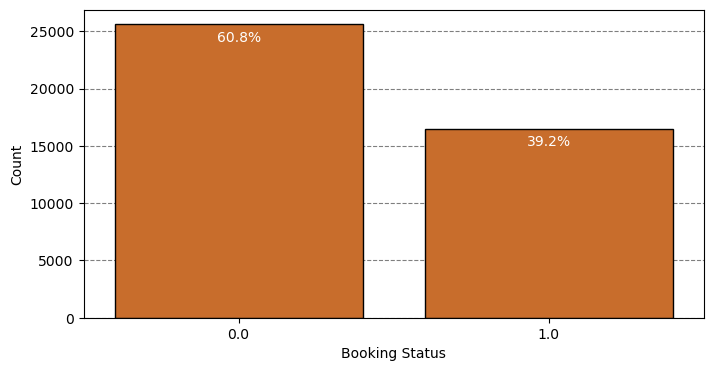

In [47]:
fig = plt.figure(figsize=(8,4))
ax = sns.countplot(data=df.query("sample == 'train'"), x='booking_status', color=main_color, edgecolor='black')
#ax.set_facecolor('#727171')
#fig.set_facecolor('#727171')
ax.grid(axis='y', color='black', linestyle='--', alpha=0.5, zorder=3)
ax.set_axisbelow(True)

ax.set_xlabel('Booking Status')
ax.set_ylabel('Count')
#ax.set_ylim(0,28000)


counts = train.groupby('booking_status')['id'].count().divide(len(train))
for i, p in enumerate(ax.patches):
    x,_ = p.get_xy()
    y = p.get_height()
    w = p.get_width()
    ax.text(x+w/2, y-1500, s=f'{round(counts.iloc[i]*100,1)}%', ha='center', color='white')
#plt.title("Most wine quality is either 5 or 6", fontweight='bold')

## 2b. Distribution of Features
<a id="2b"></a>

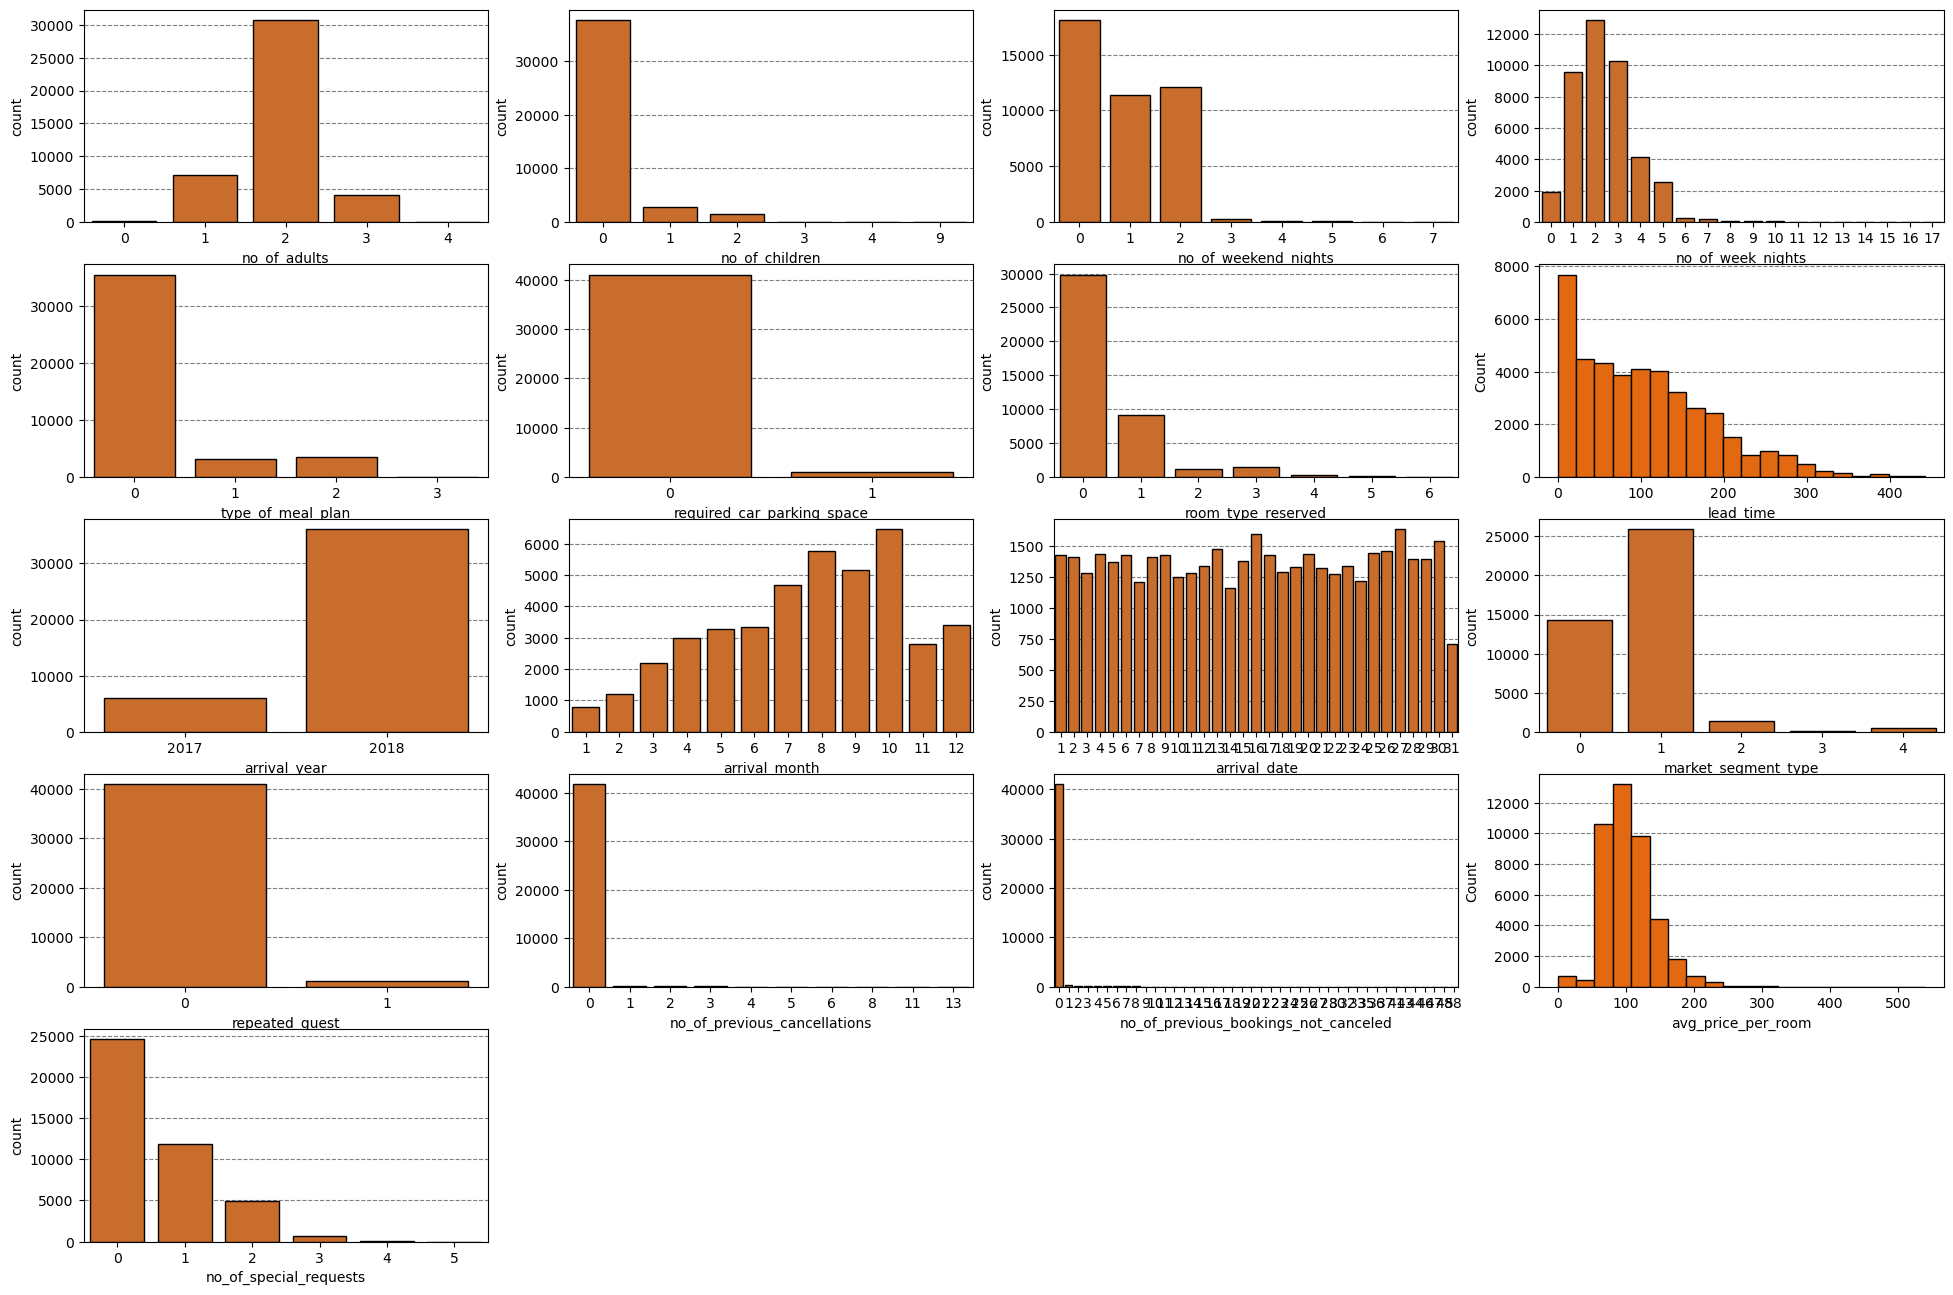

In [52]:
fig = plt.figure(figsize=(24,16))
#fig.set_facecolor('#F1ECCE')
for i, col in enumerate(original_features):
    fig.add_subplot(5,4, i+1)
    
    if train[col].dtype == 'int64' and train[col].nunique() < 100:
        ax = sns.countplot(data=train, x=col, color=main_color, edgecolor='black')
    else:
        ax = sns.histplot(data=train, x=col, bins=20, color=main_color, edgecolor='black', alpha=1)
    #ax.set_facecolor('#F1ECCE')
    ax.grid(axis='y', color='black', linestyle='--', alpha=0.5, zorder=3)
    ax.set_axisbelow(True)
    ax.set_ylabel('')


## 2c. Correlation among Variables
<a id="2c"></a>

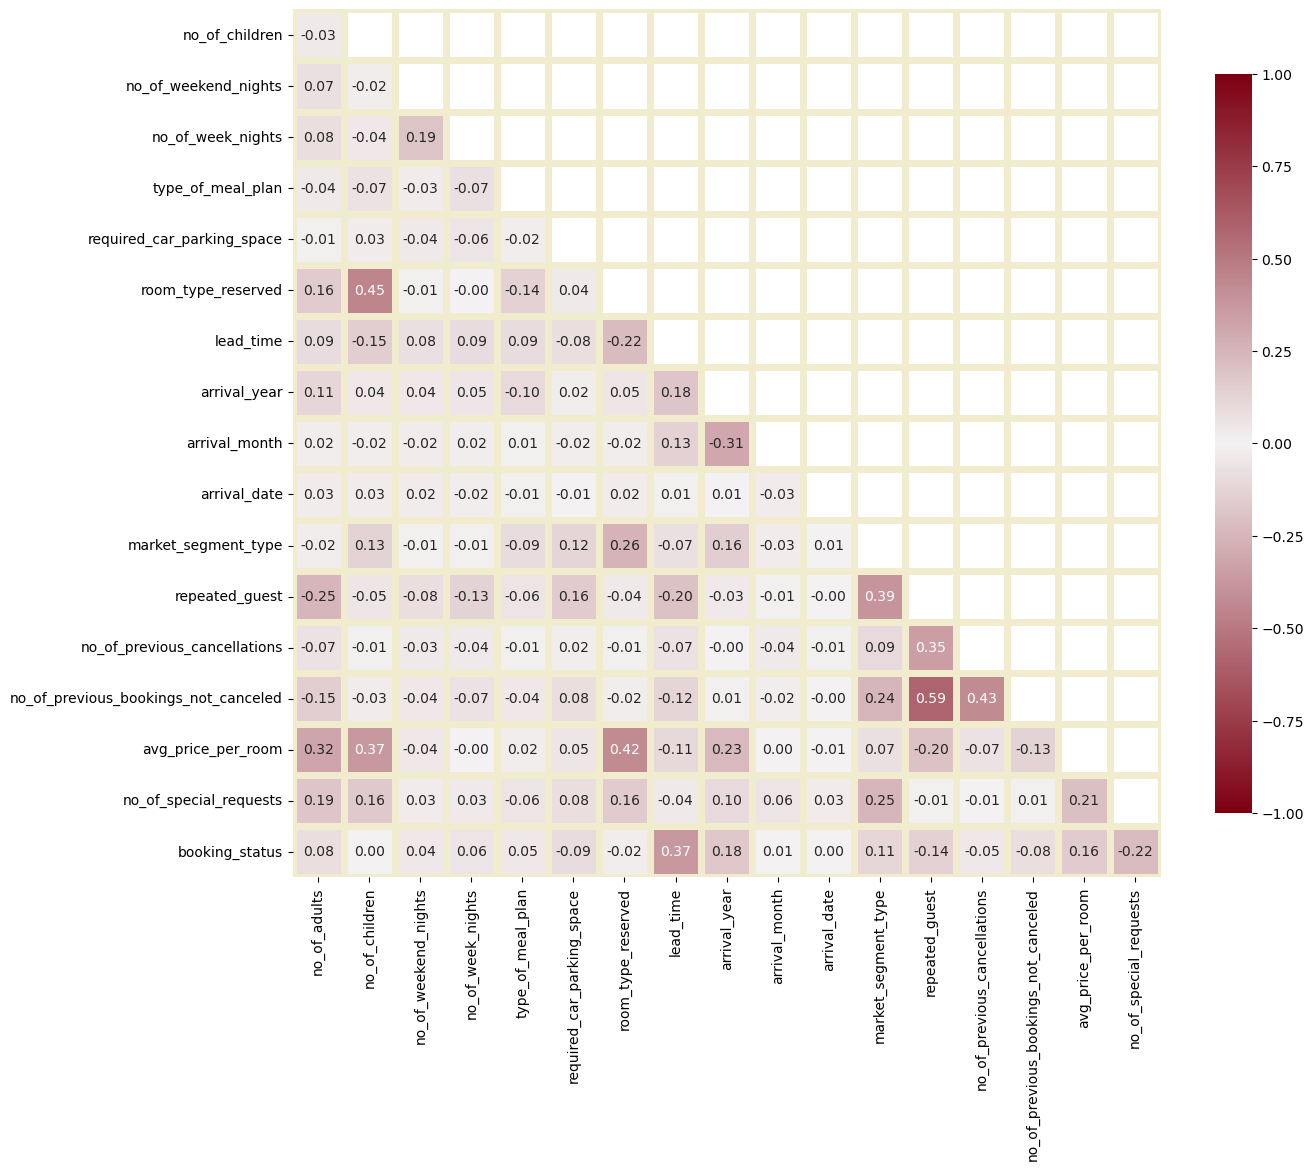

In [28]:
df_corr = train.drop(columns=['id', 'sample', 'original']).corr()
mask = np.triu(np.ones_like(df_corr, dtype=bool))[1:,:-1]

corr = df_corr.iloc[1:,:-1].copy()

# color scale
cmap = sns.diverging_palette(10,10,s=100,l=25, as_cmap=True)

fig = plt.figure(figsize=(14,12))
#fig.set_facecolor('#F1ECCE')

ax = sns.heatmap(corr, annot=True, fmt=".2f", mask=mask, square=True,cmap=cmap, vmin=-1, vmax=1, cbar_kws={"shrink": .8}, linewidths=5, linecolor="#F1ECCE")
#ax.set_facecolor('#F1ECCE')




## 2d. Relationship between Features and Wine Quality
<a id="2d"></a>

In [ ]:
fig = plt.figure(figsize=(22,16))
#fig.set_facecolor('#F1ECCE')
for i, col in enumerate(original_features):
    fig.add_subplot(5,4, i+1)
    ax = sns.boxenplot(data=train, x='booking_status', y=col, color=main_color)
    #ax.set_facecolor('#F1ECCE')
    ax.grid(axis='y', color='black', linestyle='--', alpha=0.5, zorder=3)
    ax.set_axisbelow(True)
    ax.set_xlabel('Quality')
    ax.set_title(col, weight='bold')

## 2e. Relationship among Original Features
<a id="2e"></a>

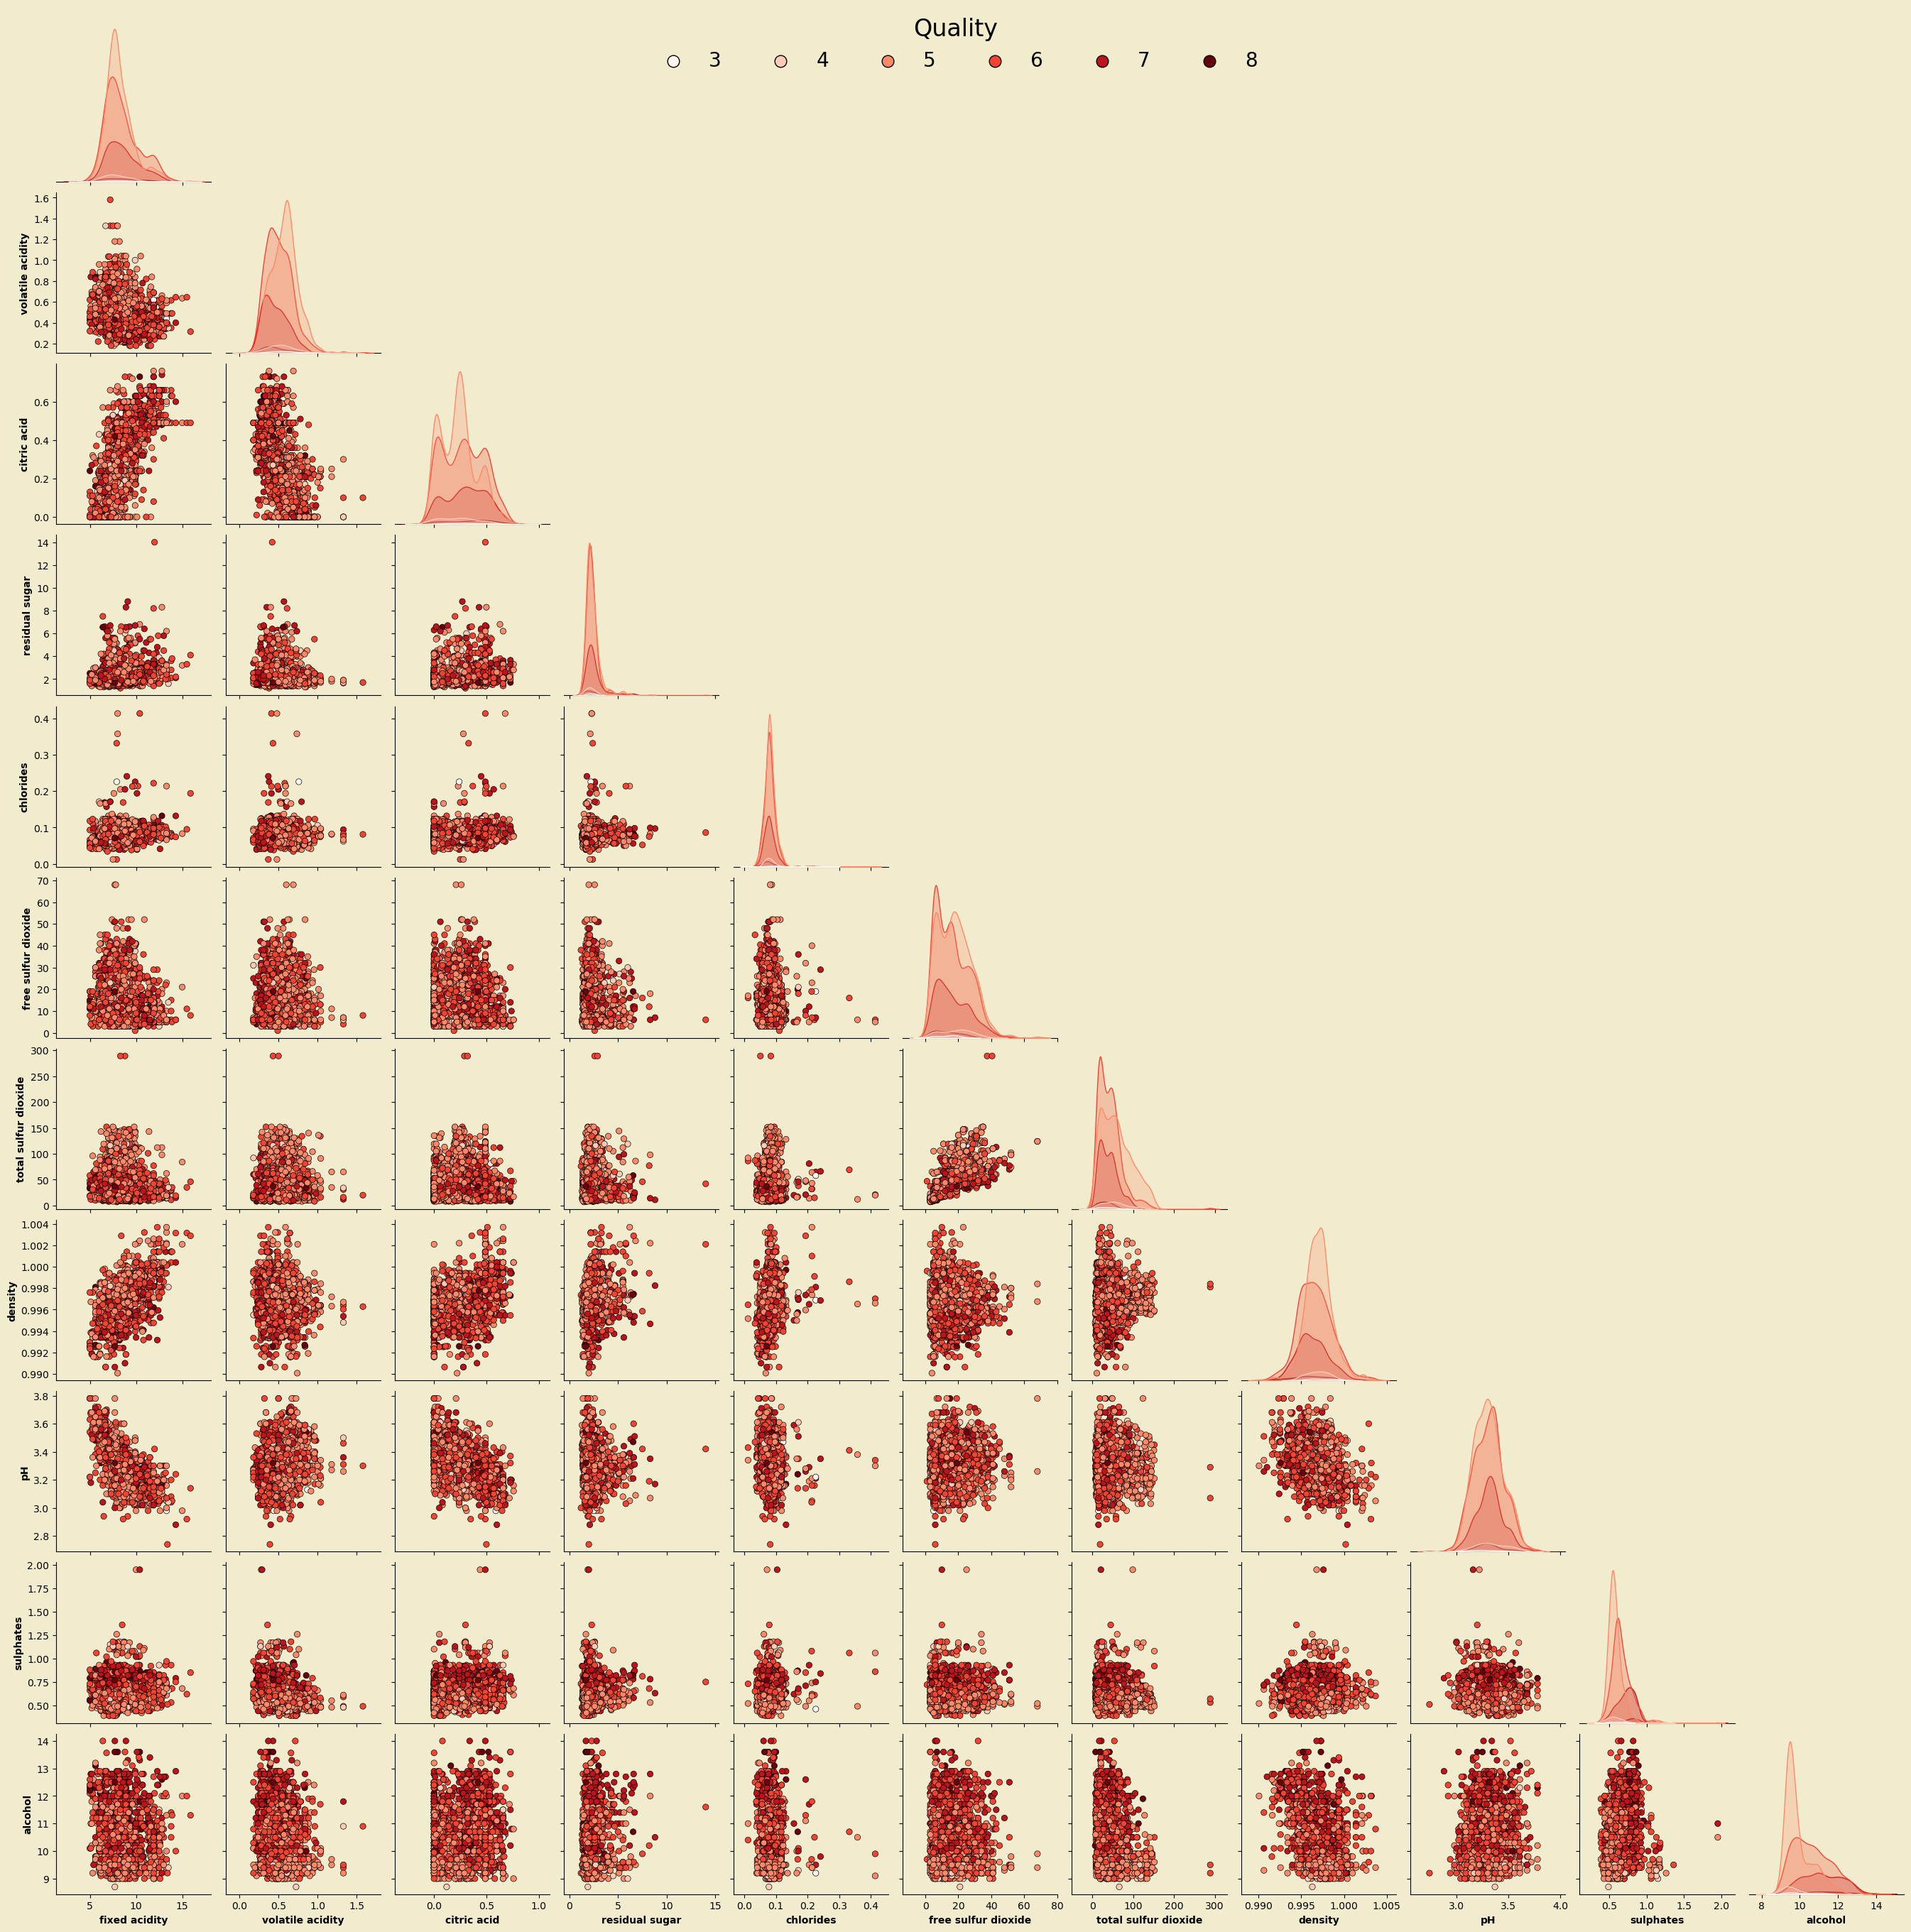

In [4]:
g = sns.pairplot(data=train, hue='quality', corner=True, palette='Reds' , diag_kind='kde',
             x_vars=features, y_vars=features,
                plot_kws = {'edgecolor':'black'})
g.fig.set_facecolor('#F1ECCE')

sns.move_legend(g, loc='upper center', fontsize=20, markerscale=2, edgecolor='black', title='Quality', title_fontsize=24, ncol=6)

# Change edgecolor for legend points to black
for ha in g.legend.legendHandles:
    ha.set_edgecolor('black')

# Set facecolor for each individual plot
for ax in g.axes.flat:
    if ax != None:
        ax.set_facecolor('#F1ECCE')
        if ax.get_xlabel() != None:
            ax.set_xlabel(ax.get_xlabel(), weight='bold')
        if ax.get_ylabel() != None:
            ax.set_ylabel(ax.get_ylabel(), weight='bold')
        

# 3. Feature Engineering
<a id="3"></a>
Since there are no missing values in this dataset I will just focus on creating/modifying features.

## 3a. Acidic Features
<a id="3a"></a>

Total acidity tells us the concentration of acids present in wine, whereas the pH level tells us how intense those acids taste. A wine with too much acidity will taste excessively sour and sharp. A wine with too little acidity will taste flabby and flat, with less defined flavors.

* **fixed acidity**: The predominant fixed acids found in wines are tartaric, malic, citric, and succinic. Their respective levels found in wine can vary greatly but in general one would expect to see:
    * 1 to 4 g/L tartaric acid,
    * 0 to 8 g/L malic acid,
    * 0 to 0.5 g/L citric acid, and
    * 0.5 to 2 g/L succinic acid.
* **volatile acidity**: Represents the fraction of acidic substances which can be freed from wine belonging to the acetic series and perceivable both to smell and taste. The two main volatile acids are:
    * acetic acid
    * ethyl acetate
* **citric acid**: Citric acid is often added to wines to increase acidity, complementing a specific flavor. Typically 0-0.5 g/l is in red wines
* **pH**: The pH of a wine is a measure of the strength and concentration of the dissociated acids present
* **sulphates**: Sulphates help preserve wine and slow chemical reactions, which cause a wine to go bad

In [306]:
df['citric per volatile'] = df['citric acid'] / df['volatile acidity']
df['citric per fixed'] = df['citric acid'] / df['fixed acidity']
df['volatile per fixed'] = df['volatile acidity'] / df['fixed acidity']

df['citric per chlorides'] = df['citric acid']/df['chlorides']
df['volatile per chlorides'] = df['volatile acidity']/df['chlorides']
df['sulphates per chlorides'] = df['sulphates']/df['chlorides']

df['pH per sulphates'] = df['pH']/df['sulphates']
df['pH per chlorides'] = df['pH'] / df['chlorides']

df['fixed acidity per chlorides'] = df['fixed acidity'] / df['chlorides']
#df['test'] = (df['fixed acidity']-df['citric acid'])/df['residual sugar']

In [631]:
df.query("quality == 7 or quality == 8").groupby('quality')['fixed acidity'].describe()

count      mean       std  min   25%  50%  75%   max
quality                                                      
7.0      333.0  8.582883  1.741375  5.1  7.20  8.2  9.8  14.3
8.0       39.0  8.312821  2.002522  5.0  6.75  8.0  9.6  12.8

Wines with lower acidity need more sulfites than higher acidity wines. At pH 3.6 or greater, wine are less stable and need additional sulphates.

In [307]:
acid_engineer_features = ['citric per volatile', 'citric per fixed', 'volatile per fixed', 'pH per sulphates', 'pH per chlorides', 'fixed acidity per chlorides', 'citric per chlorides', 'volatile per chlorides',
                         'sulphates per chlorides']

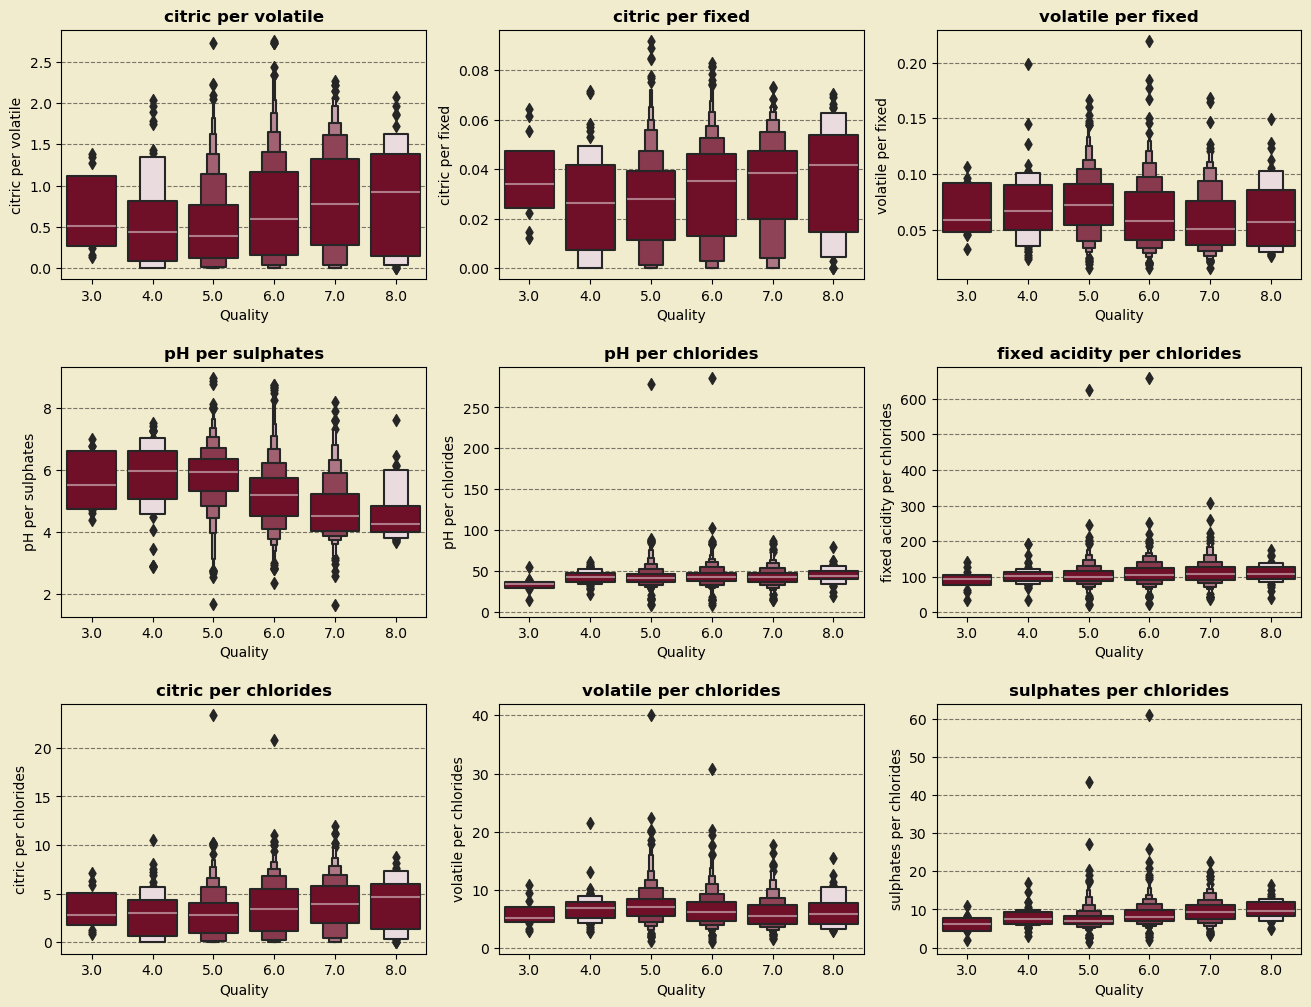

In [308]:
fig = plt.figure(figsize=(16,12))
plt.subplots_adjust(hspace=0.35)

fig.set_facecolor('#F1ECCE')
for i, col in enumerate(acid_engineer_features):
    fig.add_subplot(3,3, i+1)
    ax = sns.boxenplot(data=df.query("sample == 'train'"), x='quality', y=col, color=main_color, line_kws={'color':'white'})
    ax.set_facecolor('#F1ECCE')
    ax.grid(axis='y', color='black', linestyle='--', alpha=0.5, zorder=3)
    ax.set_axisbelow(True)
    ax.set_xlabel('Quality')
    ax.set_title(col, weight='bold')

## 3b. Sulfur Features
* Sulfur dioxide preserves wine and prevents oxidation and browning. It is usually added more to white than red wines as they have less of other antioxidants.
* **total sulfur dioxide** = **free sulfur dioxide** + **bound sulfur dioxide** 
* The amount of free sulfur dioxide to add to maintain the proper molecular level is dependent on the wine’s pH.

From (https://www.extension.iastate.edu/wine/total-sulfur-dioxide-why-it-matters-too/)

In [235]:
df['bound sulfur dioxide'] = (df['total sulfur dioxide'] - df['free sulfur dioxide'])
df['sulfur ratio'] = df['free sulfur dioxide']/df['total sulfur dioxide']
df['sulfur product'] = df['free sulfur dioxide']*df['total sulfur dioxide']
df['free sulfur dioxide per pH'] = df['free sulfur dioxide']/df['pH']
#df['f

sulfur_features = ['bound sulfur dioxide', 'sulfur ratio', 'free sulfur dioxide per pH','sulfur product']

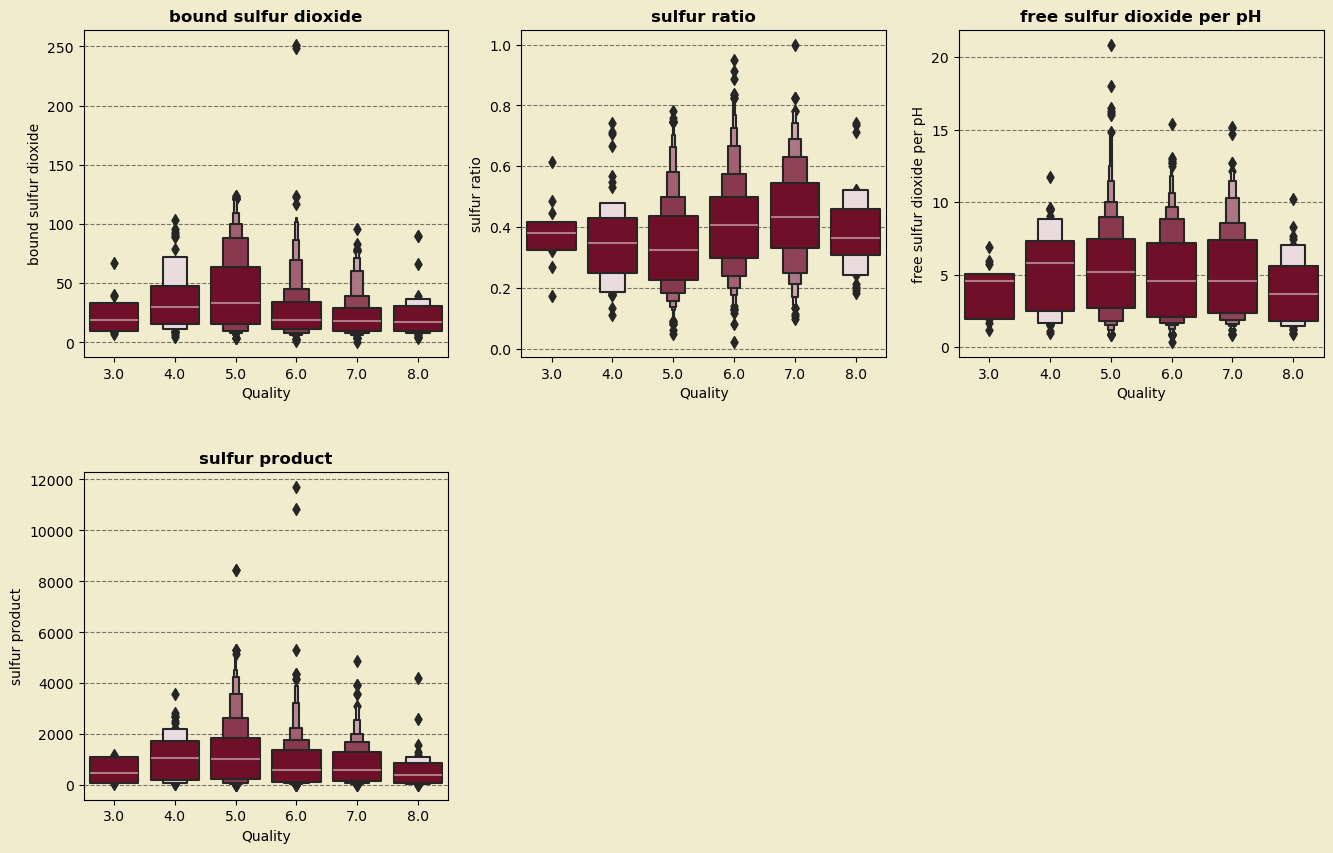

In [136]:
fig = plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=0.35)

fig.set_facecolor('#F1ECCE')
for i, col in enumerate(sulfur_features):
    fig.add_subplot(2,3, i+1)
    ax = sns.boxenplot(data=df.query("sample == 'train'"), x='quality', y=col, color=main_color, line_kws={'color':'white'})
    ax.set_facecolor('#F1ECCE')
    ax.grid(axis='y', color='black', linestyle='--', alpha=0.5, zorder=3)
    ax.set_axisbelow(True)
    ax.set_xlabel('Quality')
    ax.set_title(col, weight='bold')

## 3c. Alcohol Features

In [34]:
#df['alcohol times sulphates'] = df['alcohol'] * df['sulphates']
#df['alcohol times chlorides'] = df['alcohol'] * df['chlorides']
#df['alcohol times residual sugar'] = df['alcohol'] * df['residual sugar']
df['alcohol per density'] = df['alcohol'] / df['density']
df['sulphates per density'] = df['sulphates']/df['density']
                                                 
df['alcohol per sulphates'] = df['alcohol'] / df['sulphates']

#df['alcohol times pH'] = df['alcohol'] * df['pH']
df['alcohol per volatile acidity'] = df['alcohol'] / df['volatile acidity']
#df['alcohol per fixed acidity'] = df['alcohol'] / df['volatile acidity']
df['alcohol per total sulfur dioxide'] = df['alcohol'] / df['total sulfur dioxide']
#df['alcohol times sulfur ratio'] = df['alcohol']*df['sulfur ratio']

df['sulphates per chlorides'] = df['sulphates'] / df['chlorides']
df['alcohol per residual sugar'] = df['alcohol'] / df['residual sugar']

#df['alcohol per pH'] = df['alcohol']/df['pH']


In [399]:
alcohol_features = ['sulphates per chlorides','alcohol per volatile acidity' , 'alcohol per density', 'alcohol per residual sugar', 'sulphates per density']

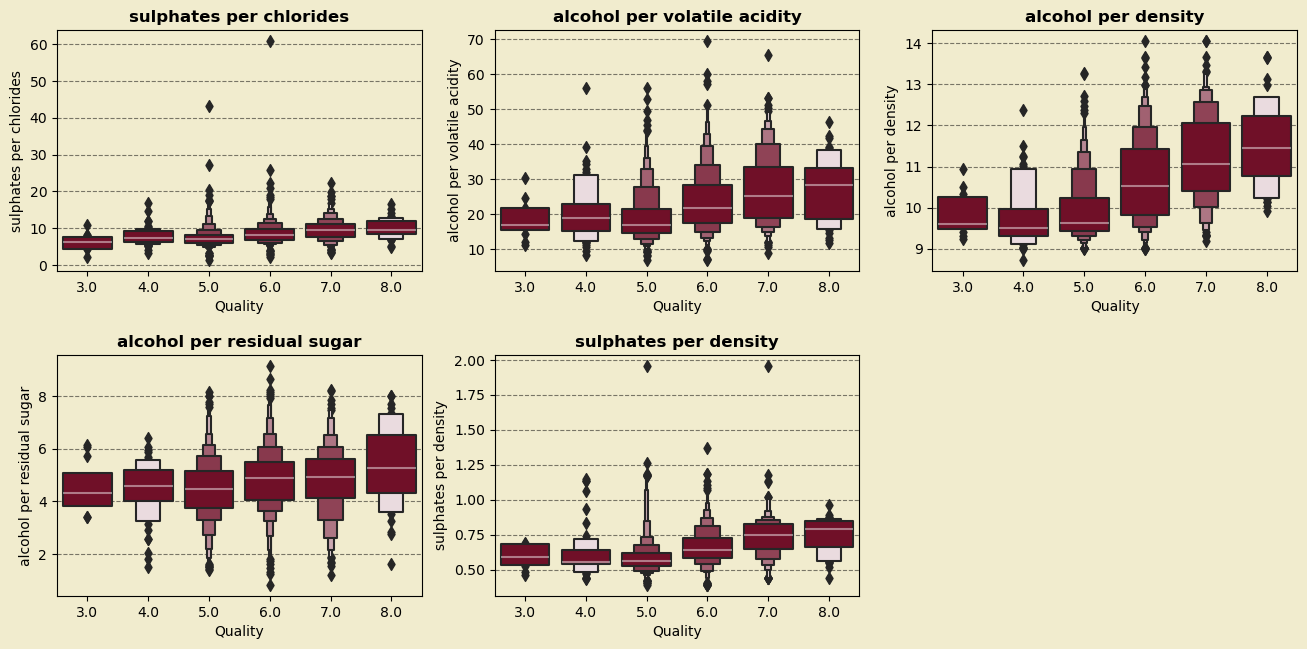

In [400]:
fig = plt.figure(figsize=(16,20))
plt.subplots_adjust(hspace=0.35)

fig.set_facecolor('#F1ECCE')
for i, col in enumerate(alcohol_features):
    fig.add_subplot(5,3, i+1)
    ax = sns.boxenplot(data=df.query("sample == 'train'"), x='quality', y=col, color=main_color, line_kws={'color':'white'})
    ax.set_facecolor('#F1ECCE')
    ax.grid(axis='y', color='black', linestyle='--', alpha=0.5, zorder=3)
    ax.set_axisbelow(True)
    ax.set_xlabel('Quality')
    ax.set_title(col, weight='bold')

The FSO2 and the pH of your wine determine how much SO2 is available in the active, molecular form to help protect the wine from oxidation and spoilage

# 4. Modelling
<a id="4"></a>


## 4b. XGBRegressor (Rounded)

In [97]:
from sklearn.metrics import roc_auc_score

In [75]:
target = 'booking_status'

In [183]:
def objective(trial):
    """Define the objective function"""

    params = {
        #'tree_method':'hist',
        #'gpu_id':0,
        #max_bin': trial.suggest_int('max_bin', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 20000),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 0.1),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 1),
        'objective':'binary:logistic',
        'eval_metric': 'auc',
        'seed':13,
    }


    cv = StratifiedKFold(5, shuffle=True, random_state=13)
    fold_scores = []
    for i, (train_idx,val_idx) in enumerate(cv.split(train[features],train[target])):
        X_train, y_train = train.loc[train_idx, features],train.loc[train_idx, target]
        X_val, y_val = train.loc[val_idx, features], train.loc[val_idx, target]
        
        model = xgb.XGBClassifier(**params)
        model.fit(X_train,
                 y_train,
                 eval_set= [(X_val,y_val)],
                 verbose=0, 
                  early_stopping_rounds=200)
        
        
        pred_val = model.predict_proba(X_val)[:,1]
        pred_test = model.predict_proba(test[features])[:,1]

        score = roc_auc_score(y_val, pred_val)
        fold_scores.append(score)
        #print(len(score))
    return np.mean(fold_scores)


In [184]:
#features = ['lead_time', 'market_segment_type', 'repeated_guest', 'avg_price_per_room', 'no_of_special_requests']
features = original_features

In [185]:
train_df = df.query("sample == 'train' and original == 0").drop(columns=['sample']).copy()
train = train_df.reset_index(drop=True)
X_train = train[features]
y_train = train['booking_status']

test_df = df.query("sample == 'test'").drop(columns=['sample']).copy()
test_df = test_df[features]
test = test_df.reset_index(drop=True)
target = 'booking_status'

In [186]:
study = optuna.create_study(direction='maximize', sampler = TPESampler())
study.optimize(objective, n_trials=200)

[I 2023-02-13 21:42:16,904] A new study created in memory with name: no-name-cfab04a7-fcd5-4057-b6e5-8d9c016b58f5
[I 2023-02-13 21:42:30,128] Trial 0 finished with value: 0.896967561696225 and parameters: {'max_depth': 3, 'learning_rate': 0.5691070972052453, 'n_estimators': 3109, 'reg_lambda': 0.04909459711996899, 'gamma': 0.6622238899322233, 'subsample': 0.8177464016813037, 'colsample_bytree': 0.838812104043895, 'min_child_weight': 2, 'reg_alpha': 0.9209960635706581}. Best is trial 0 with value: 0.896967561696225.
[I 2023-02-13 21:42:35,902] Trial 1 finished with value: 0.8342095235335396 and parameters: {'max_depth': 7, 'learning_rate': 0.8770890355078877, 'n_estimators': 9175, 'reg_lambda': 0.04367013258205659, 'gamma': 0.19813392347971284, 'subsample': 0.08918042264997254, 'colsample_bytree': 0.3503419471086065, 'min_child_weight': 0, 'reg_alpha': 0.4961776309429021}. Best is trial 0 with value: 0.896967561696225.
[I 2023-02-13 21:42:46,509] Trial 2 finished with value: 0.889739739

KeyboardInterrupt: 

In [126]:
def run_results(param_input):
    test_md = test.copy()

    X = train[features]
    Y = train['quality'] 

    test_data = test[features]

    XGB_cv_scores, XGB_imp = list(), list()
    preds = list()

    skf = StratifiedKFold(5, random_state = 13, shuffle = True)

    for train_ix, test_ix in skf.split(X, Y):

        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

        ## Building RF model
        XGB_md = xgb.XGBRegressor(**param_input).fit(X_train, Y_train,
                                               eval_set= [(X_test,Y_test)],
                             verbose=0, 
                              early_stopping_rounds=1000)

        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict(X_test)
        XGB_pred_2 = XGB_md.predict(test_data)


        ## Computing roc-auc score
        XGB_cv_scores.append(roc_curve(Y_test, XGB_pred_1))
        preds.append(XGB_pred_2)

    #XGB_cv_score = np.mean(XGB_cv_scores)    
    print('The average area under roc curve score over 10-folds is:', np.mean(XGB_cv_scores))
    
    return preds

In [102]:
best_params = {'max_depth': 2, 'learning_rate': 0.7742820535967335, 'n_estimators': 1939, 'reg_lambda': 0.018956875339031898, 'gamma': 0.8765687619763809, 'subsample': 0.5256914088809581, 'colsample_bytree': 0.4264811391818493, 'min_child_weight': 9, 'reg_alpha': 0.47594818117288434}

In [127]:
out_df = run_results(study.best_params)

The average quadratic weighted kappa score over 10-folds is: 0.5801482816358249


In [129]:
pd.DataFrame(np.transpose(np.vstack([test_df.index, pd.DataFrame(out_df).mode(axis=0).loc[0,].values])), columns=['Id', 'quality']).astype('int').to_csv("./submissions/37.csv", index=False)

In [128]:
pd.DataFrame(pd.DataFrame(out_df).mode(axis=0).loc[0,].values).value_counts()

5.0    577
6.0    490
7.0    303
4.0      1
8.0      1
dtype: int64

In [130]:
print(study.best_params)

{'max_depth': 3, 'learning_rate': 0.7335205382996955, 'n_estimators': 14004, 'reg_lambda': 0.07327984077073796, 'gamma': 0.6336083294918705, 'subsample': 0.25590443103422933, 'colsample_bytree': 0.46048489184917896, 'min_child_weight': 5, 'reg_alpha': 0.8597355374187522}


| Feature Set | Tuned Hyperparameters | CV (10-fold) Score | LB Score |
|---|---|---|---|
| Alcohol + Sulphates | {'max_depth': 8, 'learning_rate': 0.3740741087541284, 'n_estimators': 2175, 'reg_lambda': 0.08295238783428932, 'gamma': 0.7978752490002374, 'subsample': 0.17500587942205542, 'colsample_bytree': 0.057752239366825026, 'min_child_weight': 9, 'reg_alpha': 0.21099117594423974} | 0.619 | 0.5781 |
| Alcohol + Sulphates (w/ Original Data) | {'max_depth': 18, 'learning_rate': 0.35017467228284677, 'n_estimators': 13354, 'reg_lambda': 0.07605255893735538, 'gamma': 0.13691332344761054, 'subsample': 0.13081142275199056, 'colsample_bytree': 0.6901103948912658, 'min_child_weight': 7, 'reg_alpha': 0.29174137772739067 | 0.599 | 0.5808 |
| Alcohol + Sulphates + Alcohol/Sulphates (w/ Original Data) | {'max_depth': 3, 'learning_rate': 0.3604645241468048, 'n_estimators': 7912, 'reg_lambda': 0.019949989138550544, 'gamma': 0.7446930855861187, 'subsample': 0.8912613769064883, 'colsample_bytree': 0.6015049719591152, 'min_child_weight': 6, 'reg_alpha': 0.7994721845450358} | 0.589 | 0.571 |
| Alcohol + Sulphates + Density (w/ Original Data) | {'max_depth': 20, 'learning_rate': 0.3545550186529336, 'n_estimators': 11973, 'reg_lambda': 0.038244511190351334, 'gamma': 0.8045895631296827, 'subsample': 0.7469871214282923, 'colsample_bytree': 0.3162622803834475, 'min_child_weight': 8, 'reg_alpha': 0.16741463151635952} | 0.594 | 0.548 |
| Alcohol + Sulphates + Fixed Acidity (w/ Original Data) | {'max_depth': 2, 'learning_rate': 0.7742820535967335, 'n_estimators': 1939, 'reg_lambda': 0.018956875339031898, 'gamma': 0.8765687619763809, 'subsample': 0.5256914088809581, 'colsample_bytree': 0.4264811391818493, 'min_child_weight': 9, 'reg_alpha': 0.47594818117288434} | 0.605 | 0.597 |
| Alcohol + Sulphates + Fixed Acidity + Total Sulfur Dioxide (w/ Original Data) | {'max_depth': 5, 'learning_rate': 0.05149460132869435, 'n_estimators': 8803, 'reg_lambda': 0.04667786937397254, 'gamma': 0.9596592851596435, 'subsample': 0.7299393952881672, 'colsample_bytree': 0.8938612260876575, 'min_child_weight': 5, 'reg_alpha': 0.9769224844172268}| 0.604 | 0.568 |
| Alcohol + Sulphates + Fixed Acidity + pH (w/ Original Data) | {'max_depth': 4, 'learning_rate': 0.04162625988526822, 'n_estimators': 3766, 'reg_lambda': 0.057136655985602004, 'gamma': 0.24006424978875032, 'subsample': 0.33481948364994096, 'colsample_bytree': 0.5929536629294789, 'min_child_weight': 8, 'reg_alpha': 0.07426745367215262} | 0.603 | 0.555 |

Two submission files:
* Alcohol + Sulphates + Fixed Acidity (w/ Original Data)
* Alcohol + Sulphates (just train data)

In [555]:
target_df = pd.concat([xgb_reg, xgb_class, train.quality], axis=1).melt()\
                .groupby('variable')['value']\
                .value_counts(normalize=True)\
                .mul(100)\
                .rename('Percent')\
                .reset_index()

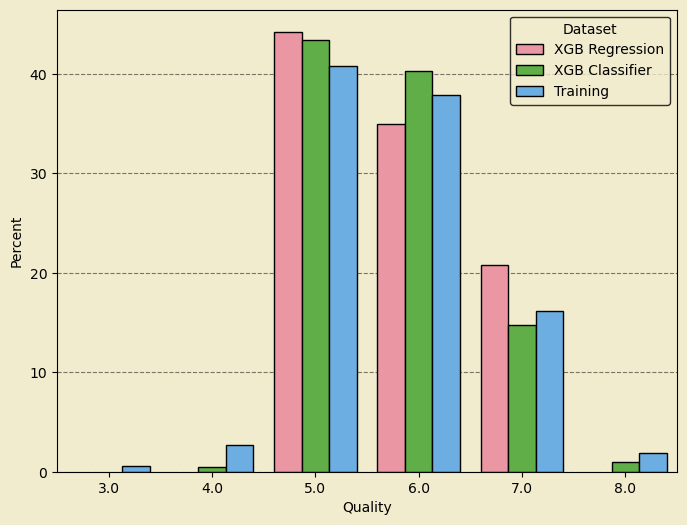

In [564]:
# Set your custom color palette
sns.set_palette(sns.color_palette([first_color, second_color]))
fig = plt.figure(figsize=(8,6))
fig.set_facecolor('#F1ECCE')

ax = sns.barplot(data=target_df, x='value',y='Percent',hue='variable', edgecolor='black', hue_order=['xgb_regressor', 'xgb_classifier', 'quality'])
ax.set_facecolor('#F1ECCE')
ax.grid(axis='y', color='black', linestyle='--', alpha=0.5, zorder=3)
ax.set_axisbelow(True)    
ax.set_xlabel('Quality')
legend_handles, _= ax.get_legend_handles_labels()

leg = ax.legend(legend_handles, ['XGB Regression', 'XGB Classifier', 'Training'], title='Dataset', facecolor='#F1ECCE', edgecolor='black')

In [292]:
test.index

Int64Index([2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065,
            ...
            3418, 3419, 3420, 3421, 3422, 3423, 3424, 3425, 3426, 3427],
           dtype='int64', length=1372)

In [289]:
clf.predict(test)

array([5., 6., 5., ..., 5., 5., 5.])

In [594]:
pd.DataFrame(np.transpose(np.vstack([test.index, pd.concat([xgb_reg, xgb_class], axis=1).mean(axis=1).astype('int')])), columns=['Id', 'quality']).to_csv("20_submission.csv", index=False)

In [493]:
model = KNeighborsRegressor(**study.best_params).fit(X_train, y_train)

In [499]:
train_df = train.copy()

In [500]:
mod = KNeighborsClassifier().fit(X_train, y_train)
train_df['pred'] = mod.predict(X_train)

In [506]:
train_df.sort_values('pred')['pred'].value_counts(normalize=True)

5.0    0.490759
6.0    0.377432
7.0    0.111381
4.0    0.013619
8.0    0.003891
3.0    0.002918
Name: pred, dtype: float64

In [495]:
np.sort(model.predict(X_train))

array([4.95238095, 4.95238095, 4.95238095, ..., 6.69047619, 6.71428571,
       6.76190476])

In [483]:
import shap

In [768]:
mod = xgb.XGBClassifier(**study.best_params)
mod.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9388097032140393,
              gamma=0.7938060835703994, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.33668783627511945,
              max_delta_step=0, max_depth=12, min_child_weight=9, missing=nan,
              monotone_constraints='()', n_estimators=7079, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0.7988650000226406, reg_lambda=0.4654776262306043,
              scale_pos_weight=None, subsample=0.2637191670043387,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [769]:
explainer = shap.TreeExplainer(mod)
shap_values = explainer.shap_values(X_train)

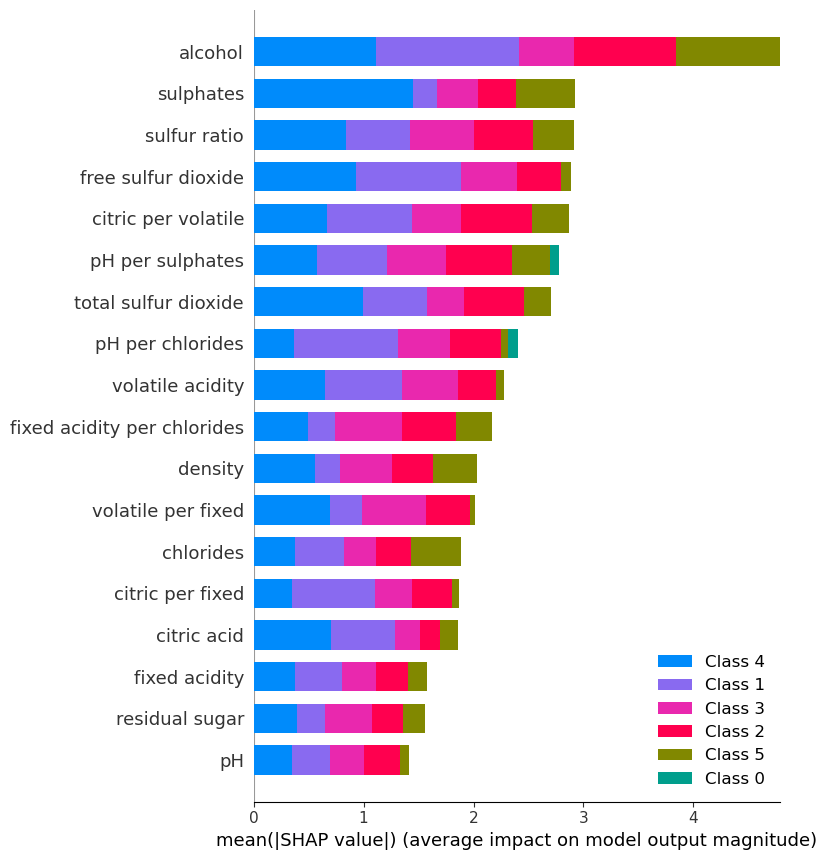

In [770]:
shap.summary_plot(shap_values, X_train.columns, max_display=50)

In [ ]:
interaction_features = ['alcohol times sulphates', 'alcohol times density', 'alcohol times fixed acid ratio', 'alcohol times pH', 'alcohol times chlorides', 

In [771]:
test = test.reset_index().rename(columns={'index':'Id'})

In [772]:
X_test = test.drop(columns=['Id']).copy()

In [729]:
test=test.iloc[: , 1:]

In [773]:
pd.DataFrame(np.transpose(np.vstack([test['Id'], mod.predict(X_test).astype('int')])), columns=['Id', 'quality']).to_csv("8_submission.csv", index=False)

In [193]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df.drop(columns=['Id', 'quality']).values)
pca_df = df.copy()
pca_df['pca-one'] = pca_result[:,0]
pca_df['pca-two'] = pca_result[:,1] 

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.93072601 0.05376608]


<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

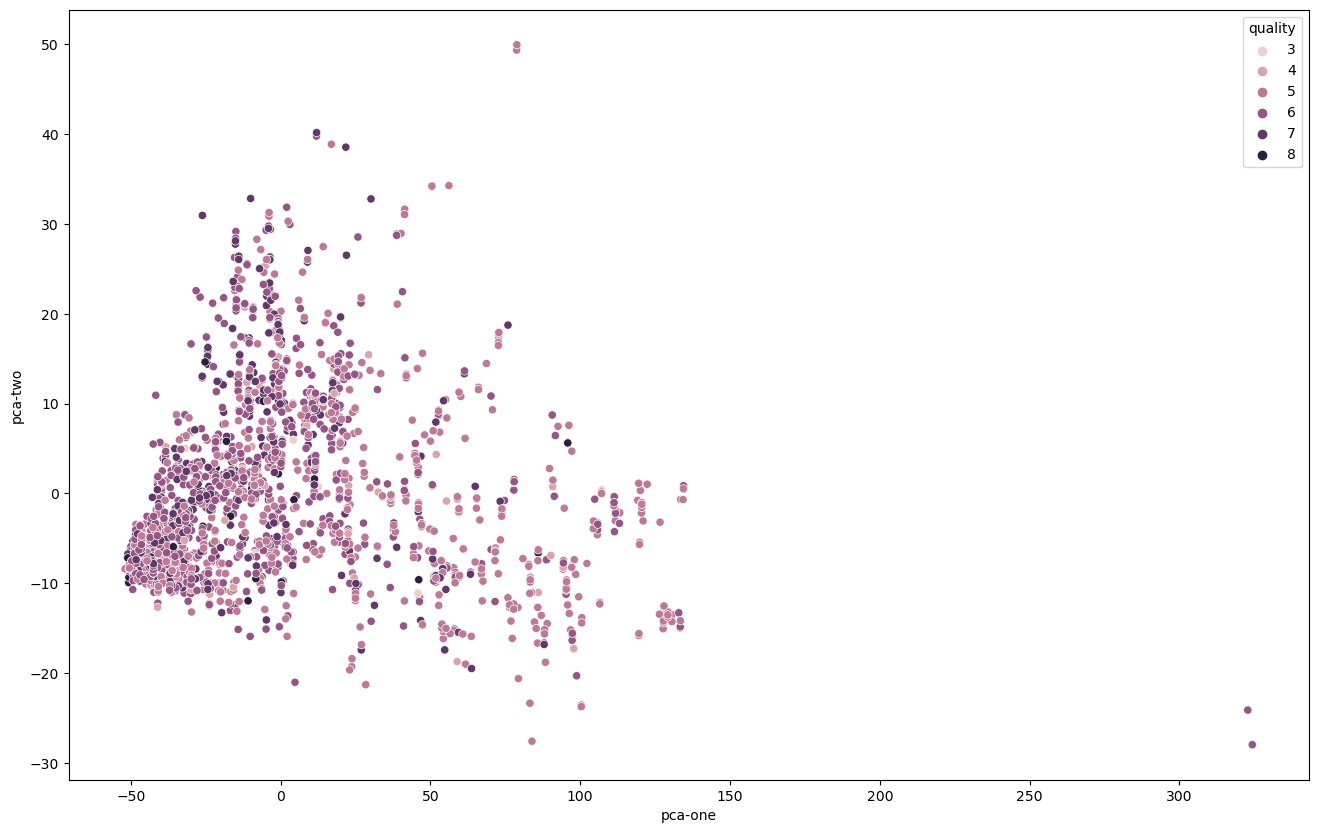

In [195]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="quality",
    data=pca_df,
    legend="full",
    alpha=1
)

In [196]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

In [197]:
tsne_results = tsne.fit_transform(df.drop(columns=['Id', 'quality']))

C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2056 samples in 0.001s...
[t-SNE] Computed neighbors for 2056 samples in 0.123s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2056
[t-SNE] Computed conditional probabilities for sample 2000 / 2056
[t-SNE] Computed conditional probabilities for sample 2056 / 2056
[t-SNE] Mean sigma: 3.393434
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.236385
[t-SNE] KL divergence after 300 iterations: 0.800397


In [198]:
tsne_results[:,1]

array([16.89159  ,  1.101669 , -1.5433168, ..., 10.596118 , -4.7029657,
       10.899529 ], dtype=float32)

In [199]:
tsne_df = df[['quality']].copy()
tsne_df['tsne_1'] = tsne_results[:,0]
tsne_df['tsne_2'] = tsne_results[:,1]

<AxesSubplot:xlabel='tsne_1', ylabel='tsne_2'>

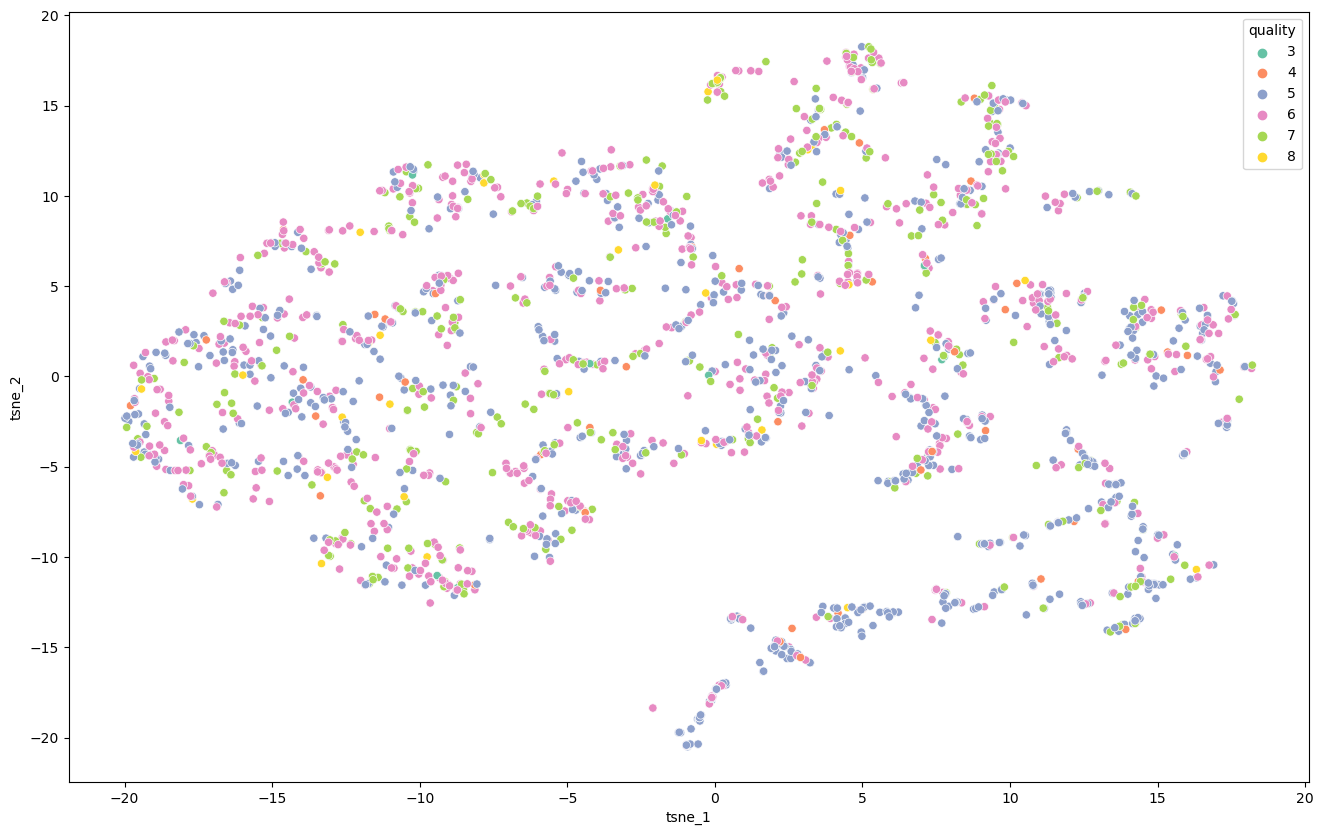

In [200]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue="quality",
    data=tsne_df,
    palette='Set2'

)

In [ ]:
g = sns.jointplot(data=df, x="sulfur ratio", y="density", hue='quality', palette='Reds', edgecolor='black', kind='scatter')
g.ax_marg_x.set_facecolor('#F1ECCE')
g.ax_marg_y.set_facecolor('#F1ECCE')
g.fig.set_facecolor('#F1ECCE')
g.ax_joint.set_facecolor('#F1ECCE')